<a href="https://colab.research.google.com/github/ShuichiroTsuda/Kaggle_Predict_Future_Sales/blob/master/Predict_Future_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download Datasets

In [26]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
import time

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


Download 100%.


In [27]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

sales_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
shops.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
item_categories.csv: Skipping, found more recently modified local copy (use --force to force download)
items.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [28]:
!unzip items.csv.zip 
!unzip sample_submission.csv.zip 
!unzip sales_train.csv.zip
!unzip test.csv.zip

Archive:  items.csv.zip
replace items.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: items.csv               
Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
Archive:  sales_train.csv.zip
replace sales_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sales_train.csv         
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                


## Dependencies

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

## Loading Data

In [0]:
test = pd.read_csv('test.csv', 
                   dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})
item_categories = pd.read_csv('item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('items.csv', 
                    dtype={'item_name': 'str', 'item_id': 'int32','item_category_id': 'int32'})
shops = pd.read_csv('shops.csv', 
                    dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('sales_train.csv', 
                    parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [31]:
print(test.head())

   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


In [32]:
print(item_categories.head())

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4


In [33]:
print(items.head())

                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2                40
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3                40
4        ***КОРОБКА (СТЕКЛО)                       D        4                40


In [34]:
print(shops.head())

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4


In [35]:
print(sales.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-02-01               0       59    22154      999.00             1
1 2013-03-01               0       25     2552      899.00             1
2 2013-05-01               0       25     2552      899.00            -1
3 2013-06-01               0       25     2554     1709.05             1
4 2013-01-15               0       25     2555     1099.00             1


## Join Datasets

In [0]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [37]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [38]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


## Time Period

In [39]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


## Data Leakages
I use only the "shop_id" and "item_id" that appear on the test set.

In [0]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

lk_train = train[train['shop_id'].isin(test_shop_ids)]
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [41]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


## Data Preprocesssing
I dropped 
- the data with "item_price <= 0".
- the text features.

I aggregate the data by month.

In [0]:
train = train.query('item_price > 0')

In [0]:
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [0]:
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [0]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)


In [0]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [0]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

## Show Current Dataset

In [48]:
print(train_monthly.head().T)
print(train_monthly.describe().T)

                        0       1       2       3       4
date_block_num       0.00    0.00    0.00    0.00    0.00
shop_id              2.00    2.00    2.00    2.00    2.00
item_id           5572.00 5643.00 5583.00 7893.00 7894.00
item_category_id     2.00    2.00    5.00    6.00    6.00
item_price       10730.00 4775.21 1188.30 5970.00 1490.00
mean_item_price   1532.86 2387.60  594.15 1990.00 1490.00
item_cnt             9.00    0.00    2.00    3.00    1.00
mean_item_cnt        1.29    0.00    1.00    1.00    1.00
transactions         7.00    2.00    2.00    3.00    1.00
year              2013.00 2013.00 2013.00 2013.00 2013.00
month                0.00    0.00    0.00    0.00    0.00
                      count     mean     std  ...      50%      75%       max
date_block_num   6734448.00    16.50    9.81  ...    16.50    25.00     33.00
shop_id          6734448.00    31.64   17.56  ...    34.50    47.00     59.00
item_id          6734448.00 11041.89 6210.74  ... 11265.50 16068.25  2

## EDA

In [0]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

### The behavior of sales along the year

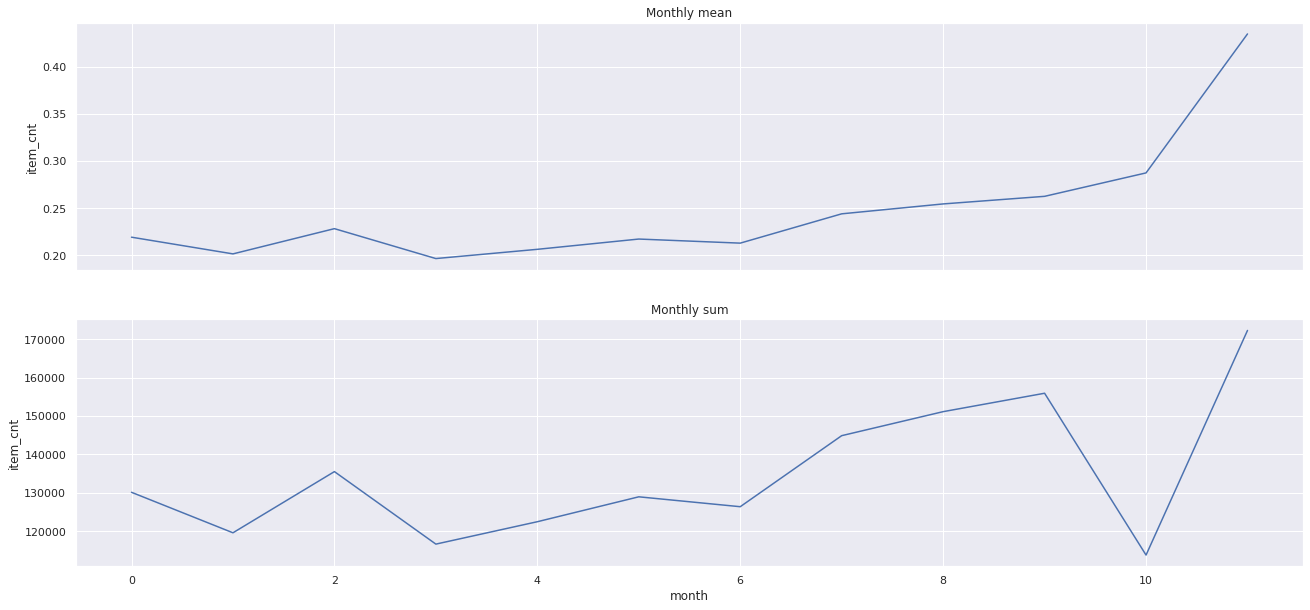

In [50]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

### The amount of sales in regard to every category

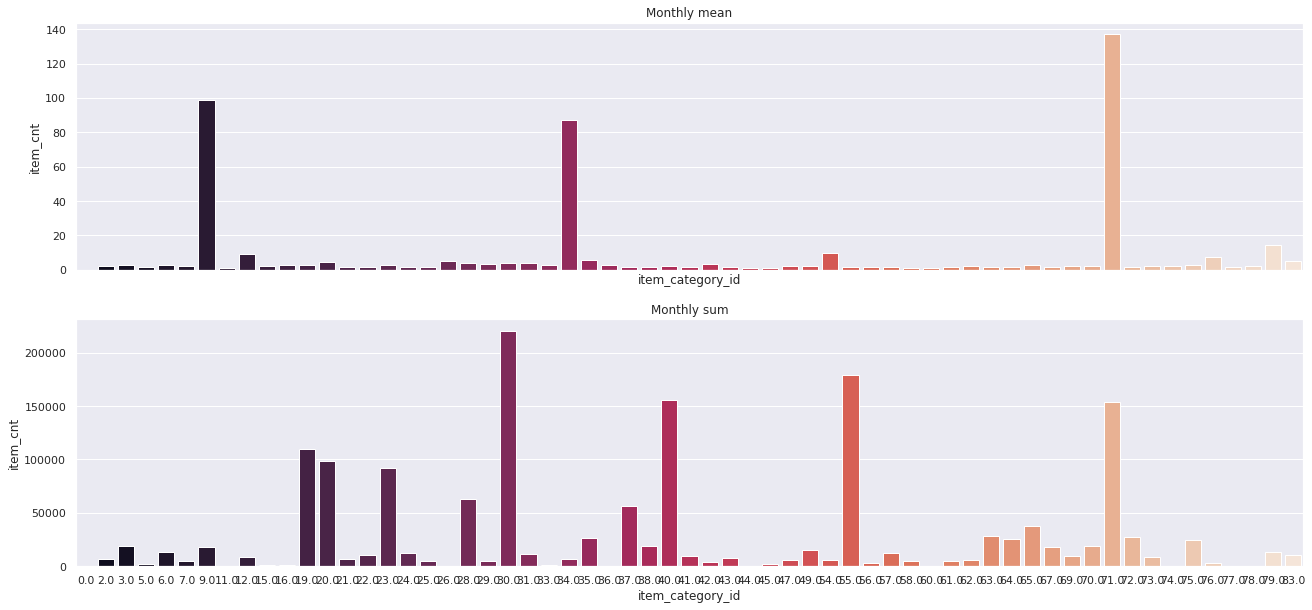

In [51]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

## Checking for Outliers

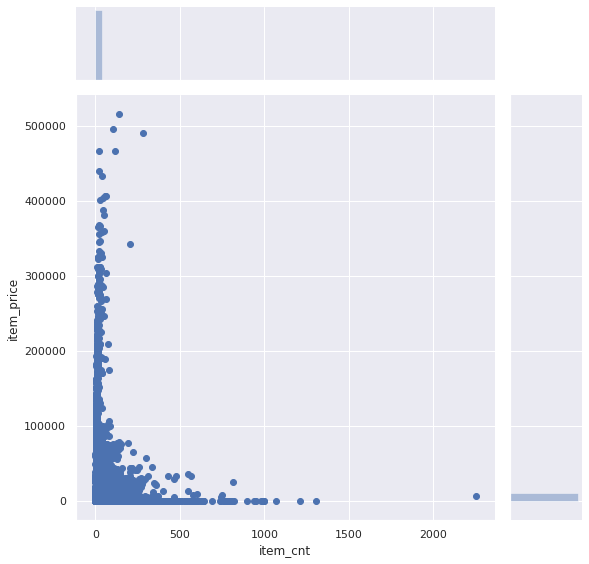

In [52]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

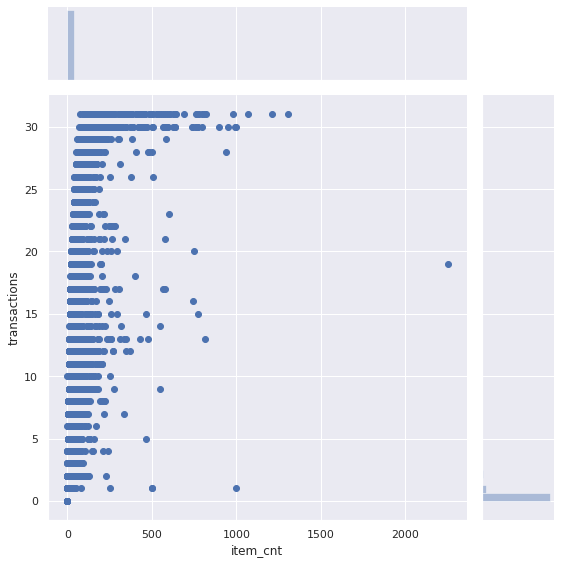

In [53]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda
